In [ ]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %                   SCF-TB - PROXY APPLICATION                      %
# %                   A.M.N. Niklasson, M. Kulichenko. T1, LANL       %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Total Energy Function:                                            %
# % E = 2Tr[H0(D-D0)] + (1/2)*sum_i U_i q_i^2 +                       %
# %      + (1/2)sum_{i,j (i!=j)} q_i C_{ij} q_j - Efield*dipole       %
# % dipole = sum_i R_{i} q_i                                          %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from dftorch.DM_Fermi_x import DM_Fermi_x
import torch
import numpy as np
import sys
import os
### path to PYSEQM ###
sys.path.insert(1, "/home/maxim/Projects/git2/PYSEQM_dev/")
#from seqm.seqm_functions.read_xyz import read_xyz
import scipy.io as sio
import math
import pandas as pd
import importlib
#import matplotlib.pyplot as plt

import dftorch
import importlib
import dftorch.CoulombMatrix
#importlib.reload(dftorch.CoulombMatrix)
from dftorch.CoulombMatrix import CoulombMatrix_vectorized, Ewald_Real_Space_vectorized
from dftorch.SCF import SCF, SCF_adaptive_mixing, SCFx

from dftorch.H0andS import H0_and_S_vectorized, H0_and_S_vectorized_OLD_FOR_POLY
from dftorch.Constants import Constants, ConstantsTest
from dftorch.nearestneighborlist import vectorized_nearestneighborlist
from dftorch.Energy import Energy, EnergyShadow
from dftorch.Tools import fractional_matrix_power_symm
from dftorch.Forces import Forces, ForcesShadow
from dftorch.BondIntegral import *
from dftorch.Tools import ordered_pairs_from_TYPE
from dftorch.Structure import Structure
from dftorch.DM_Fermi import DM_Fermi
from dftorch.Fermi_PRT import Canon_DM_PRT, Fermi_PRT
from dftorch.Kernel_Fermi import Kernel_Fermi
from dftorch.MD import initialize_velocities

from dftorch.io import read_xyz_traj_data, read_xyz, write_XYZ_trajectory
import time
#import matplotlib.colors as mcolors

from dftorch.RepulsiveSpline import get_repulsion_energy
torch.set_default_dtype(torch.float64)
print(torch.cuda.memory_allocated() / 1e9, 'GB')

0.0 GB


/home/maxim/anaconda3/envs/sedacs_1/lib/python3.9/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
torch.cuda.empty_cache()

In [1]:
%%time
# Initial data, load atoms and coordinates, etc in COORD.dat
device = 'cuda'
#const = Constants('/home/maxim/Projects/DFTB/DFTorch/tests/sk_orig/mio-1-1/mio-1-1').to(device)
const = Constants('/home/maxim/Projects/DFTB/DFTorch/tests/sk_orig/ptbp/complete_set').to(device)
Efield = 0*0.3*torch.tensor([-.3,0.4,0.0], device=device).T # In arbitrary direction  Works ony in 0-field!!!
Te = 3000.0                       # Some electronic temperature in Kelvin, Possible bug at high tempertures!!!

# species, coordinates = read_xyz(['3HDP_Ni.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([60,61,62], device=device)

# species, coordinates = read_xyz(['protein.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([100,100,100], device=device)

# species, coordinates = read_xyz(['COORD.xyz'], sort=False) #Input coordinate file
#LBox = torch.tensor([9,4,4], device=device)
# LBox = torch.tensor([20,20,20], device=device)
# LBox = torch.tensor([30,30,30], device=device)

species, coordinates = read_xyz(['water_30.xyz'], sort=False) #Input coordinate file
LBox = torch.tensor([30,30,30], device=device)

# species, coordinates = read_xyz(['COORD_8WATER.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([20,20,20], device=device)

# species, coordinates = read_xyz(['COORD_H.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([90,40,40], device=device)

# species, coordinates = read_xyz(['C.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([90,40,40], device=device)

# species, coordinates = read_xyz(['COORD_Ni.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([9,4,4], device=device)

# species, coordinates = read_xyz(['C2.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([80,40,40], device=device)

# species, coordinates = read_xyz(['C840.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([50,50,50], device=device) #36

# species, coordinates = read_xyz(['solvated_1600.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([33,33,33], device=device)
# LBox = torch.tensor([100,100,100], device=device)

# species, coordinates = read_xyz(['gs_solvated_4k.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([100,100,100], device=device)

# species, coordinates = read_xyz(['solvated_ac_4k.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([36,36,36], device=device)

# species, coordinates = read_xyz(['solvated_ac_2k.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([27.2,27.2,27.2], device=device)

# species, coordinates = read_xyz(['solvated_ac_2k_relaxed.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([27.2,27.2,27.2], device=device)

# species, coordinates = read_xyz(['solvated_ac_2k_react.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([27.2,27.2,27.2], device=device)

# species, coordinates = read_xyz(['solvated_ac_glyc_1k_react.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([20,20,20], device=device)

# species, coordinates = read_xyz(['NaCl.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([27,27,27], device=device)

# species, coordinates = read_xyz(['NaCl_1.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([27,27,27], device=device)



req_grad = False
TYPE = torch.tensor(species[0], dtype=torch.int64, device=device)
RX = torch.tensor(coordinates[0,:,0], device=device, dtype=torch.get_default_dtype(),
                    requires_grad=req_grad)
RY = torch.tensor(coordinates[0,:,1], device=device, dtype=torch.get_default_dtype(),
                    requires_grad=req_grad)
RZ = torch.tensor(coordinates[0,:,2], device=device, dtype=torch.get_default_dtype(),
                    requires_grad=req_grad)
R_tensor, R_orb, coeffs_tensor, R_rep_tensor, rep_splines_tensor = get_skf_tensors(TYPE, const)
const.set_params()

structure = Structure(TYPE, RX, RY, RZ, LBox, const, charge = 0, device=device)

structure.RX = (structure.RX) % structure.LBox[0]; 
structure.RY = (structure.RY) % structure.LBox[1];
structure.RZ = (structure.RZ) % structure.LBox[2];


# but first the neighborlist


nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, nrnnStruct, \
        neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type  = \
        vectorized_nearestneighborlist(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox,
        8.0, structure.Nats, const, upper_tri_only=False, remove_self_neigh=False, min_image_only=False, verbose=True); # 8 for...
        
# Get Hamiltonian, Overlap, atomic DM = D0 (vector only), etc, 
D0, H0, dH0, S, dS = H0_and_S_vectorized(
                                structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.Nats,
                                structure.diagonal, structure.H_INDEX_START,structure.H_INDEX_END, structure.Znuc,
                                nnRx, nnRy, nnRz, nnType,
                                const, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type,
                                R_orb, coeffs_tensor,
                                verbose=True)
del nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, nrnnStruct, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type

# D0, H0, dH0, S, dS = H0_and_S_vectorized_OLD_FOR_POLY(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, structure.Nats,
#                                 structure.diagonal, structure.H_INDEX_START,structure.H_INDEX_END, structure.Znuc,
#                                 nrnnlist, nnRx, nnRy, nnRz, nnType,
#                                 const, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type,
#                                 R_orb, coeffs_tensor,
#                                 verbose=True)

Vr, dVr = get_repulsion_energy(
                        R_rep_tensor, rep_splines_tensor,
                        structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, 6.0, structure.Nats, 
                        const,verbose=True);

NameError: name 'Constants' is not defined

NameError: name 'np' is not defined

In [5]:
# torch.save(H0, 'H0_large_pad.pt')
# torch.save(dH0, 'dH0_large_pad.pt')

# torch.save(S, 'S_large_pad.pt')
# torch.save(dS, 'dS_large_pad.pt')

# torch.save(Vr, 'Vr_large_pad.pt')
# torch.save(dVr, 'dVr_large_pad.pt')


# H0_large_pad = torch.load('H0_large_pad.pt')
# dH0_large_pad = torch.load('dH0_large_pad.pt')

# S_large_pad = torch.load('S_large_pad.pt')
# dS_large_pad = torch.load('dS_large_pad.pt')

# Vr_large_pad = torch.load('Vr_large_pad.pt')
# dVr_large_pad = torch.load('dVr_large_pad.pt')

In [6]:
# %%time
# # Initial data, load atoms and coordinates, etc in COORD.dat
# device = 'cuda'
# const = ConstantsTest().to(device)
# Efield = 0*0.3*torch.tensor([-.3,0.4,0.0], device=device).T # In arbitrary direction  Works ony in 0-field!!!
# Te = 3000.0                       # Some electronic temperature in Kelvin, Possible bug at high tempertures!!!

# # species, coordinates = read_xyz(['3HDP_Ni.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([60,61,62], device=device)

# # species, coordinates = read_xyz(['protein.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([100,100,100], device=device)

# # species, coordinates = read_xyz(['COORD.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([9,4,4], device=device)

# # species, coordinates = read_xyz(['COORD_8WATER.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([10,10,10], device=device)

# # species, coordinates = read_xyz(['COORD_H.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([90,40,40], device=device)

# # species, coordinates = read_xyz(['C.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([90,40,40], device=device)

# # species, coordinates = read_xyz(['COORD_Ni.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([9,4,4], device=device)

# # species, coordinates = read_xyz(['C2.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([80,40,40], device=device)

# species, coordinates = read_xyz(['C840.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([70,70,70], device=device) #36

# # species, coordinates = read_xyz(['solvated_1600.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([33,33,33], device=device)
# #LBox = torch.tensor([100,100,100], device=device)

# # species, coordinates = read_xyz(['gs_solvated_4k.xyz'], sort=False) #Input coordinate file
# # LBox = torch.tensor([100,100,100], device=device)

# req_grad = False
# TYPE = torch.tensor(species[0], dtype=torch.int64, device=device)
# RX = torch.tensor(coordinates[0,:,0], device=device, dtype=torch.get_default_dtype(),
#                     requires_grad=req_grad)
# RY = torch.tensor(coordinates[0,:,1], device=device, dtype=torch.get_default_dtype(),
#                     requires_grad=req_grad)
# RZ = torch.tensor(coordinates[0,:,2], device=device, dtype=torch.get_default_dtype(),
#                     requires_grad=req_grad)
# structure = Structure(TYPE, RX, RY, RZ, LBox, const, charge = 0, device=device)
# # but first the neighborlist
# R_tensor, R_orb, coeffs_tensor, R_rep_tensor, rep_splines_tensor = get_skf_tensors(TYPE, const)

# nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, nrnnStruct, \
#         neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type  = \
#         vectorized_nearestneighborlist(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox,
#         4.0, structure.Nats, const, upper_tri_only=False, remove_self_neigh=False, min_image_only=False, verbose=True);
        
# # Get Hamiltonian, Overlap, atomic DM = D0 (vector only), etc, 
# # D0, H0, dH0, S, dS = H0_and_S_vectorized(
# #                                 structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, structure.Nats,
# #                                 structure.diagonal, structure.H_INDEX_START,structure.H_INDEX_END, structure.Znuc,
# #                                 nrnnlist, nnRx, nnRy, nnRz, nnType,
# #                                 const, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type,
# #                                 R_orb, coeffs_tensor,
# #                                 verbose=True)

# D0, H0, dH0, S, dS = H0_and_S_vectorized_OLD_FOR_POLY(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, structure.Nats,
#                                 structure.diagonal, structure.H_INDEX_START,structure.H_INDEX_END, structure.Znuc,
#                                 nrnnlist, nnRx, nnRy, nnRz, nnType,
#                                 const, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type,
#                                 R_orb, coeffs_tensor,
#                                 verbose=True)

# Vr, dVr = get_repulsion_energy(
#                         R_rep_tensor, rep_splines_tensor,
#                         structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, 4.9, structure.Nats, 
#                         const,verbose=True);

In [7]:
# MAT_D0 = sio.loadmat('D0.mat')['D0']
# MAT_H0 = sio.loadmat('H0.mat')['H0']
# MAT_S = sio.loadmat('S.mat')['S']

# (abs(D0.cpu().numpy() - MAT_D0)).max(), (abs(H0.cpu().numpy() - MAT_H0)).max(), (abs(S.cpu().numpy() - MAT_S)).max()

In [8]:
# plt.figure(figsize=(5,5))
# im = plt.imshow((H0.cpu().numpy() - MAT_H0)[:10,:10], cmap="viridis", 
#                 #norm=mcolors.LogNorm(vmin=data.min(), vmax=data.max()),
#                    interpolation=None)
# plt.colorbar(label="Value")


In [9]:
%%time
# Parameters for the Coulomb summations
Coulomb_acc = 1e-5
TIMERATIO = 10

COULVOL = LBox[0] * LBox[1] * LBox[2]
SQRTX = math.sqrt(-math.log(Coulomb_acc))
CALPHA = math.sqrt(math.pi) * ((TIMERATIO * structure.Nats / (COULVOL ** 2)) ** (1.0 / 6.0))
COULCUT = SQRTX / CALPHA

#### or ####
COULCUT = 10.0
CALPHA = SQRTX/COULCUT
############

if COULCUT > 50.0:
    COULCUT = 50.0
    CALPHA = SQRTX / COULCUT

#Rcut = 10.42
Rcut = COULCUT

# Get full Coulomb matrix. In principle we do not need an explicit representation of the Coulomb matrix C!
nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, \
nrnnStruct, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type = \
vectorized_nearestneighborlist( structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, Rcut, structure.Nats, const,
                                upper_tri_only=False, remove_self_neigh=False, verbose=True)
                                
C, dCC = CoulombMatrix_vectorized(structure, structure.RX,structure.RY,structure.RZ,structure.LBox,
                                    structure.Hubbard_U, structure.Hubbard_U_sr, structure.TYPE,structure.Nats,
                                    structure.HDIM,Coulomb_acc,TIMERATIO,nnRx,nnRy,nnRz,nrnnlist,nnType, neighbor_I, neighbor_J,
                                    structure.H_INDEX_START,structure.H_INDEX_END,
									CALPHA, COULCUT, verbose=True)
del nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, nrnnStruct, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type
COULCUT, CALPHA

  t <neighbor list> 0.1 s

CoulombMatrix_vectorized
  Do Coulomb Real
  Coulomb_Real t 0.0 s
  Doing Coulomb k
   LMAX: 10
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
  Coulomb_k t 13.4 s

CPU times: user 13.5 s, sys: 45.5 ms, total: 13.5 s
Wall time: 13.5 s


(10.0, 0.33930702122075557)

In [10]:
#with torch.no_grad():
dftorch_params = {
	'coul_method': 'full',
	'Coulomb_acc': 1e-5, # coulomb accuracy for full coulomb calcs or t_err for PME
	'cutoff': 10.0, # coulomb cutoff
	'PME_order': 4,
				}

H, Hcoul, Hdipole, KK, D, q, f, mu0, _, _, _ = SCFx(dftorch_params, structure, D0,
        H0, S, Efield, C,
        structure.RX, structure.RY, structure.RZ,
        structure.Nocc, structure.Hubbard_U, structure.Znuc, structure.Nats, Te,
        alpha=0.5, MaxRank=30, start_Krylov=3,
        acc=1e-6, FelTol=1e-6, MAX_ITER=20, debug=False)

Etot,Eband0,Ecoul,Edipole,S_ent = Energy(H0, structure.Hubbard_U, Efield, D0, C, D, q,
                                            structure.RX, structure.RY, structure.RZ, f, Te) # Energy calculation - 2*Te*S_ent
del Hdipole
Etot+Vr ,Eband0,Ecoul,Edipole,S_ent, Vr

### Do SCF ###


/home/maxim/anaconda3/envs/sedacs_1/lib/python3.9/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


  Initial DM_Fermi


W1117 13:40:05.287191 2388803 site-packages/torch/fx/experimental/symbolic_shapes.py:6679] [1/0] failed during evaluate_expr(Abs(zuf1 - 3536.0) > 1.0e-10, hint=None, size_oblivious=False, forcing_spec=False
E1117 13:40:05.288886 2388803 site-packages/torch/fx/experimental/recording.py:299] [1/0] failed while running evaluate_expr(*(Abs(zuf1 - 3536.0) > 1.0e-10, None, False, False), **{})



Starting cycle
Iter 1
  Hcoul 0.0 s
  DM_Fermi 4.8 s
  Z@Dorth@Z.T 0.0 s
Res = 12.945370095, dEb = 71013.192339521, dEc = 638.201915217, t = 8.7 s

Iter 2
  Hcoul 0.0 s
  DM_Fermi 4.8 s
  Z@Dorth@Z.T 0.0 s
Res = 3.447822069, dEb = 192.353140185, dEc = 90.302695686, t = 8.7 s

Iter 3
  Hcoul 0.0 s
  DM_Fermi 4.8 s
  Z@Dorth@Z.T 0.0 s
Res = 0.962621005, dEb = 40.654467635, dEc = 23.611700935, t = 8.7 s

Iter 4
  Hcoul 0.0 s
  DM_Fermi 4.9 s
  Z@Dorth@Z.T 0.0 s


/home/maxim/anaconda3/envs/sedacs_1/lib/python3.9/site-packages/torch/_inductor/lowering.py:1725: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


rank: 0 0.004035371579242943
rank: 1 0.0005076026444680828
rank: 2 5.5328936471169304e-05
rank: 3 8.132797367936783e-06
rank: 4 1.1667403089810506e-06
rank: 5 1.85569529818434e-07
Res = 0.274209610, dEb = 98258.453452197, dEc = 9.091633446, t = 76.1 s

Iter 5
  Hcoul 0.0 s
  DM_Fermi 5.0 s
  Z@Dorth@Z.T 0.0 s
rank: 0 6.437934727111956e-07
Res = 0.000032606, dEb = 4.256637154, dEc = 0.001058414, t = 20.3 s

Iter 6
  Hcoul 0.0 s
  DM_Fermi 5.2 s
  Z@Dorth@Z.T 0.0 s
rank: 0 8.387948209634267e-08
Res = 0.000001288, dEb = 0.000490158, dEc = 0.000006604, t = 21.2 s

Iter 7
  Hcoul 0.0 s
  DM_Fermi 5.3 s
  Z@Dorth@Z.T 0.0 s
rank: 0 2.722666676739776e-08
Res = 0.000000168, dEb = 0.000003364, dEc = 0.000000538, t = 21.3 s



(tensor(-96898.5340, device='cuda:0'),
 tensor(-98333.2518, device='cuda:0'),
 tensor(515.1948, device='cuda:0'),
 tensor(-0., device='cuda:0'),
 tensor(8.7326e-09, device='cuda:0'),
 tensor(919.5230, device='cuda:0'))

In [ ]:
#with torch.no_grad():
dftorch_params = {
	'coul_method': 'full',
	'Coulomb_acc': 1e-5, # coulomb accuracy for full coulomb calcs or t_err for PME
	'cutoff': 10.0, # coulomb cutoff
	'PME_order': 4,
				}

H, Hcoul, Hdipole, KK, D, q, f, mu0, _, _, _ = SCFx(dftorch_params, structure, D0,
        H0, S, Efield, C,
        structure.RX, structure.RY, structure.RZ,
        structure.Nocc, structure.Hubbard_U, structure.Znuc, structure.Nats, Te,
        alpha=0.5, MaxRank=30, start_Krylov=3,
        acc=1e-6, FelTol=1e-6, MAX_ITER=20, debug=False)

Etot,Eband0,Ecoul,Edipole,S_ent = Energy(H0, structure.Hubbard_U, Efield, D0, C, D, q,
                                            structure.RX, structure.RY, structure.RZ, f, Te) # Energy calculation - 2*Te*S_ent
del Hdipole
Etot+Vr ,Eband0,Ecoul,Edipole,S_ent, Vr

### Do SCF ###
  Initial DM_Fermi

Starting cycle
Iter 1
  Hcoul 0.0 s
  DM_Fermi 0.8 s
  Z@Dorth@Z.T 0.0 s
Res = 12.943977356, dEb = 71012.453125000, dEc = 638.087890625, t = 0.9 s

Iter 2
  Hcoul 0.0 s
  DM_Fermi 0.8 s
  Z@Dorth@Z.T 0.0 s
Res = 3.447508097, dEb = 192.304687500, dEc = 90.286865234, t = 0.9 s

Iter 3
  Hcoul 0.0 s
  DM_Fermi 0.8 s
  Z@Dorth@Z.T 0.0 s
Res = 0.962539673, dEb = 40.648437500, dEc = 23.607910156, t = 0.9 s

Iter 4
  Hcoul 0.0 s
  DM_Fermi 0.8 s
  Z@Dorth@Z.T 0.0 s
rank: 0 0.004034977871924639
rank: 1 0.0005077447276562452
rank: 2 5.5354172218358144e-05
rank: 3 8.122376129904296e-06
rank: 4 1.166158426713082e-06
rank: 5 1.8637203424987092e-07
Res = 0.274194688, dEb = 98258.218750000, dEc = 9.090576172, t = 3.0 s

Iter 5
  Hcoul 0.0 s
  DM_Fermi 0.8 s
  Z@Dorth@Z.T 0.0 s
rank: 0 2.0828274500672705e-05
rank: 1 3.125726379948901e-06
rank: 2 4.1947544104914414e-07
Res = 0.000114256, dEb = 4.253906250, dEc = 0.001464844, t = 2.0 s

Iter 6
  Hcoul 0.0 s
  DM_Fermi

(tensor(-96897.8828, device='cuda:0'),
 tensor(-98332.4688, device='cuda:0'),
 tensor(515.1016, device='cuda:0'),
 tensor(-0., device='cuda:0'),
 tensor(6.8490e-06, device='cuda:0'),
 tensor(919.5223, device='cuda:0'))

In [10]:
%%time
with torch.no_grad():
	# Ftot, Fcoul, Fband0, Fdipole, FPulay, FScoul, FSdipole, Frep
    Ftot, _, _, _, _, _, _, _ = \
    Forces( H, H0, S, C,
            D, D0,
            dH0, dS, dCC, dVr,
            Efield, structure.Hubbard_U, q,
            structure.RX, structure.RY, structure.RZ,
            structure.Nats, structure.H_INDEX_START, structure.H_INDEX_END, const, structure.TYPE)
Ftot.abs().max()

Forces t 0.9 s

CPU times: user 682 ms, sys: 181 ms, total: 863 ms
Wall time: 860 ms


tensor(8.9877, device='cuda:0')

In [11]:
Ftot

tensor([[ 0.7427,  0.1326, -0.2508,  ..., -0.3757, -0.4561,  0.7816],
        [ 0.8540, -0.5288, -0.1965,  ...,  0.4440, -0.4012, -0.1973],
        [-0.0997, -0.4913,  0.0920,  ..., -0.1243,  0.1031, -0.0952]],
       device='cuda:0')

In [12]:
# Initial BC for n
torch.manual_seed(0)

cuda_sync = True
MaxRank = 25
FelTol = 1e-4;
F2V = 0.01602176487/1.660548782;
MVV2KE = 166.0538782/1.602176487;
KE2T = 1/0.000086173435;
fric = 0.0;

temperature_K = 200.0

n = q; n_0 = q; n_1 = q; n_2 = q; n_3 = q; n_4 = q; n_5 = q;
mu_0 = mu0; mu_1 = mu0; mu_2 = mu0; mu_3 = mu0; mu_4 = mu0; mu_5 = mu0;
C0 = -6; C1 = 14; C2 = -8; C3 = -3; C4 = 4; C5 = -1; # Coefficients for modified Verlet integration
kappa = 1.82; alpha = 0.018;                         # Coefficients for modified Verlet integration
dt = 0.25;                              # Time step in fs
#VX = 0*structure.RX; VY = 0*structure.RX; VZ = 0*structure.RX;        # Initialize velocities
VX, VY, VZ = initialize_velocities(structure, temperature_K=temperature_K, remove_com=True, rescale_to_T=True, remove_angmom=True)
KK0 = KK;
K0Res = KK@(q-n);

atom_ids = torch.repeat_interleave(torch.arange(len(structure.n_orbitals_per_atom), device=S.device), structure.n_orbitals_per_atom) # Generate atom index for each orbital
E_array = []
T_array = []
Ek_array = []
Ep_array = []
Res_array = []

EPOT = Etot+Vr
for MD_step in range(10):  # MAIN MD LOOP

	if cuda_sync: torch.cuda.synchronize()

	del C, dCC, D0, H0, dH0, S, dS, Vr, dVr, H, D
	start_time = time.perf_counter()
	print("########## Step = {:} ##########".format(MD_step, ))
	

	# OUTPUTS FOR SHADOW MD SIMULATIONS
	EKIN = 0.5*MVV2KE*torch.sum(structure.Mnuc*(VX**2+VY**2+VZ**2))           # Kinetic energy in eV (MVV2KE: unit conversion)
	Temperature = (2/3)*KE2T*EKIN/structure.Nats              # Statistical temperature in Kelvin
	Energ = EKIN + EPOT;                                # Total Energy in eV, Total energy fluctuations Propto dt^2
	Time = MD_step*dt;
	ResErr = torch.norm(q-n)/(structure.Nats**0.5)                      # ResErr Propto dt^2
	
	E_array.append(Energ.item())
	T_array.append(Temperature.item())
	Ek_array.append(EKIN.item())
	Ep_array.append(EPOT.item())
	Res_array.append(ResErr.item())

	if MD_step%5 == 0:
		comm_string = f"Etot = {Energ:.6f} eV, Epot = {EPOT:.6f} eV, Ekin = {EKIN:.6f} eV, T = {Temperature:.2f} K, Res = {ResErr:.6f}, mu = {mu0:.4f} eV\n"
		write_XYZ_trajectory('solvated_trj.xyz', structure, comm_string, step=MD_step)

	VX = VX + 0.5*dt*(F2V*Ftot[0]/structure.Mnuc) - fric*VX;      # First 1/2 of Leapfrog step
	VY = VY + 0.5*dt*(F2V*Ftot[1]/structure.Mnuc) - fric*VY;      # F2V: Unit conversion
	VZ = VZ + 0.5*dt*(F2V*Ftot[2]/structure.Mnuc) - fric*VZ;      # -c*V c>0 => Fricition
	del Ftot

	# update positions and translate coordinates if go beyond box
	# Apply periodic boundary conditions
	structure.RX = (structure.RX + dt*VX) % structure.LBox[0]; 
	structure.RY = (structure.RY + dt*VY) % structure.LBox[1];
	structure.RZ = (structure.RZ + dt*VZ) % structure.LBox[2];

	if cuda_sync: torch.cuda.synchronize()
	tic2 = time.perf_counter()
	tic2_1 = time.perf_counter()

	nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, nrnnStruct, \
			neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type  = \
	vectorized_nearestneighborlist(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox,
			8.0, structure.Nats, const, upper_tri_only=False, remove_self_neigh=False, min_image_only=False, verbose=False); # 8 for...
			
	# Get Hamiltonian, Overlap, atomic DM = D0 (vector only), etc, 
	D0, H0, dH0, S, dS = H0_and_S_vectorized(
									structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.Nats,
									structure.diagonal, structure.H_INDEX_START,structure.H_INDEX_END, structure.Znuc,
									nnRx, nnRy, nnRz, nnType,
									const, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type,
									R_orb, coeffs_tensor,
									verbose=False)
	del nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, nrnnStruct, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type

	if cuda_sync: torch.cuda.synchronize()
	print("2_1: {:.3f} s".format(time.perf_counter()-tic2_1))
	tic2_1 = time.perf_counter()

	
	# D0, H0, dH0, S, dS = H0_and_S_vectorized_OLD_FOR_POLY(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, structure.Nats,
    #                             structure.diagonal, structure.H_INDEX_START,structure.H_INDEX_END, structure.Znuc,
    #                             nrnnlist, nnRx, nnRy, nnRz, nnType,
    #                             const, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type,
    #                             R_orb, coeffs_tensor,
    #                             verbose=False)
	
	Z = fractional_matrix_power_symm(S, -0.5)
	n = 2*n_0 - n_1 - kappa*K0Res + alpha*(C0*n_0+C1*n_1+C2*n_2+C3*n_3+C4*n_4+C5*n_5)
	n_5 = n_4; n_4 = n_3; n_3 = n_2; n_2 = n_1; n_1 = n_0; n_0 = n

	Rcut = COULCUT
	# Get full Coulomb matrix. In principle we do not need an explicit representation of the Coulomb matrix C!
	nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, \
	nrnnStruct, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type = \
	vectorized_nearestneighborlist( structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, Rcut, structure.Nats, const,
									upper_tri_only=False, remove_self_neigh=False, verbose=False)
									
	C, dCC = CoulombMatrix_vectorized(structure, structure.RX,structure.RY,structure.RZ,structure.LBox,
										structure.Hubbard_U, structure.Hubbard_U_sr, structure.TYPE,structure.Nats,
										structure.HDIM,Coulomb_acc,TIMERATIO,nnRx,nnRy,nnRz,nrnnlist,nnType, neighbor_I, neighbor_J,
										structure.H_INDEX_START,structure.H_INDEX_END,
										CALPHA, COULCUT, verbose=False)
	del nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, nrnnStruct, neighbor_I, neighbor_J, IJ_pair_type, JI_pair_type

	if cuda_sync: torch.cuda.synchronize()
	print("2_2: {:.3f} s".format(time.perf_counter()-tic2_1))
	tic2_1 = time.perf_counter()

	
	CoulPot = C @ n
	Hcoul_diag = structure.Hubbard_U[atom_ids] * n[atom_ids] + CoulPot[atom_ids]        
	Hcoul = 0.5 * (Hcoul_diag.unsqueeze(1) * S + S * Hcoul_diag.unsqueeze(0))
	H = H0 + Hcoul
	#Dorth,Q,e,f,mu0 = DM_Fermi_x((Z.T @ H @ Z).to(torch.float64), Te, structure.Nocc, mu_0=None, m=18, eps=1e-9, MaxIt=50)
	Dorth,Q,e,f,mu0 = DM_Fermi_x((Z.T @ H @ Z), Te, structure.Nocc, mu_0=None, m=18, eps=1e-9, MaxIt=50)
	Dorth = Dorth.to(torch.get_default_dtype())
	D = Z @ Dorth @ Z.T
	DS = 2 * (D * S.T).sum(dim=1)  # same as DS = 2 * torch.diag(D @ S)
	q = -1.0 * structure.Znuc
	q.scatter_add_(0, atom_ids, DS) # sums elements from DS into q based on number of AOs, e.g. x4 p orbs for carbon or x1 for hydrogen
	del Hcoul_diag, Hcoul, Dorth, DS

	if cuda_sync: torch.cuda.synchronize()
	print("2_3: {:.3f} s".format(time.perf_counter()-tic2_1))

	
	# Update Kernel %%

	if cuda_sync: torch.cuda.synchronize()
	print("2 HAM: {:.3f} s".format(time.perf_counter()-tic2))
	tic3 = time.perf_counter()

	NoRank = False;
	do_full_kernel = False
	Res = q - n


	if MD_step%1000 == 0 and do_full_kernel:
		###
		KK,_ = Kernel_Fermi(structure, mu0,Te,structure.Nats,H,C,S,Z,Q,e)
		KK0 = KK;
		K0Res = KK0@Res;
		###
		1
	elif NoRank:
		#K0Res = KK0*Res
		KK0 = -0.2
		K0Res = KK0*Res
	else: # Preconditioned Low-Rank Krylov SCF acceleration
		K0Res = KK@Res
		vi = torch.zeros(structure.Nats,MaxRank, device=S.device)
		fi = torch.zeros(structure.Nats,MaxRank, device=S.device)
		# Preconditioned residual
		K0Res = KK0 @ Res
		dr = K0Res.clone()
		I = 0
		Fel = torch.tensor(float('inf'), dtype=q.dtype, device=q.device)

		while (I < MaxRank) and (Fel > FelTol):
			# Normalize current direction
			norm_dr = torch.norm(dr)
			if norm_dr < 1e-8:
				print('zero norm_dr')
				break
			vi[:, I] = dr / norm_dr
			# Modified Gram-Schmidt against previous vi
			if I > 0:
				# vi[:, I] = vi[:, I] - Vprev @ (Vprev.T @ vi[:, I])
				Vprev = vi[:, :I]                        # (Nats, I)
				vi[:, I] = vi[:, I] - Vprev @ (Vprev.T @ vi[:, I])
			norm_vi = torch.norm(vi[:, I])
			if norm_vi < 1e-8:
				print('zero norm_vi')
				break
			vi[:, I] = vi[:, I] / norm_vi
			v = vi[:, I].clone()  # current search direction

			# dHcoul from a unit step along v (atomic) mapped to AO via atom_ids
			d_CoulPot = C @ v
			d_Hcoul_diag = structure.Hubbard_U[atom_ids] * v[atom_ids] + d_CoulPot[atom_ids]
			d_Hcoul = 0.5 * (d_Hcoul_diag.unsqueeze(1) * S + S * d_Hcoul_diag.unsqueeze(0))
			H1_orth = Z.T @ d_Hcoul @ Z
			# First-order density response (canonical Fermi PRT)
			#_, D1 = Canon_DM_PRT(H1_orth, Te, Q, e, mu0, 10)
			_, D1 = Fermi_PRT(H1_orth, Te, Q, e, mu0)
			D1 = Z @ D1 @ Z.T
			D1S = 2 * torch.diag(D1 @ S)
			# dq (atomic) from AO response
			dq = torch.zeros(structure.Nats, dtype=q.dtype, device=q.device)
			dq.scatter_add_(0, atom_ids, D1S)
			del d_CoulPot, d_Hcoul_diag, d_Hcoul, H1_orth, D1, D1S

			# New residual (df/dlambda), preconditioned
			dr = dq - v
			dr = KK0 @ dr
			# Store fi column
			fi[:, I] = dr
			# Small overlap O and RHS (vectorized)
			rank_m = I + 1
			F_small = fi[:, :rank_m]                  # (Nats, r)
			O = F_small.T @ F_small                   # (r, r)
			rhs = F_small.T @ K0Res                   # (r,)
			# Solve O Y = rhs (stable) instead of explicit inverse
			Y = torch.linalg.solve(O, rhs)            # (r,)
			# Residual norm in the subspace
			Fel = torch.norm(F_small @ Y - K0Res)
			print("rank: {:}, Fel = {:.6f}".format(I, Fel.item() ))
			I += 1

		# Combine correction: K0Res := V Y
		step = (vi[:, :rank_m] @ Y)

		# ##### Trust region relative to the preconditioned residual
		# base = torch.norm(KK0 @ Res)
		# sn   = torch.norm(step)
		# if sn > 1.25 * base and sn > 0:
		# 	step = step * ((1.25 * base) / sn)
		# #####

		K0Res = step                          # (Nats,)
		del vi, fi, v, Y, 
	
	
	if cuda_sync: torch.cuda.synchronize()
	print("3 KER: {:.3f} s".format(time.perf_counter()-tic3))
	tic4 = time.perf_counter()

	
	Etot,Eband0,Ecoul,Edipole,S_ent = EnergyShadow(H0, structure.Hubbard_U, Efield, D0, C, D, q, n,	
                                            structure.RX, structure.RY, structure.RZ, f, Te) # Energy calculation - 2*Te*S_ent
	

	Vr, dVr = get_repulsion_energy(
                        R_rep_tensor, rep_splines_tensor,
                        structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, 6.0, structure.Nats,
                        const,verbose=False);
	
	if cuda_sync: torch.cuda.synchronize()
	tic4_3 = time.perf_counter()


	EPOT = Etot+Vr
	Ftot, Fcoul, Fband0, Fdipole, FPulay, FScoul, FSdipole, Frep = \
    	ForcesShadow( H, H0, S, C,
            D, D0,
            dH0, dS, dCC, dVr,
            Efield, structure.Hubbard_U, q, n,
            structure.RX, structure.RY, structure.RZ,
            structure.Nats, structure.H_INDEX_START, structure.H_INDEX_END, const, structure.TYPE, verbose=False)
	
	if cuda_sync: torch.cuda.synchronize()
	print("4_3: {:.3f} s".format(time.perf_counter()-tic4_3))


	VX = VX + 0.5*dt*(F2V*Ftot[0]/structure.Mnuc) - fric*VX;      # Integrate second 1/2 of leapfrog step
	VY = VY + 0.5*dt*(F2V*Ftot[1]/structure.Mnuc) - fric*VY;      # - c*V  c > 0 => friction
	VZ = VZ + 0.5*dt*(F2V*Ftot[2]/structure.Mnuc) - fric*VZ;      
	print("ETOT = {:.8f}, EPOT = {:.8f}, EKIN = {:.8f}, T = {:.8f}, ResErr = {:.6f}, t = {:.1f} s\n".format(Energ, EPOT.item(), EKIN.item(),  Temperature.item(), ResErr.item(), time.perf_counter()-start_time ))
	print(torch.cuda.memory_allocated() / 1e9, 'GB\n')
	del Q, Z


	if cuda_sync: torch.cuda.synchronize()
	print("4 F AND E: {:.3f} s".format(time.perf_counter()-tic4))
	#tic4 = time.perf_counter()


########## Step = 0 ##########
  t <neighbor list> 0.0 s

H0_and_S t 0.3 s

2_1: 0.282 s
  t <neighbor list> 0.1 s

CoulombMatrix_vectorized
  Coulomb_Real t 0.0 s
  Coulomb_k t 7.1 s

2_2: 7.906 s
2_3: 0.939 s
2 HAM: 9.127 s
rank: 0, Fel = 0.006949
rank: 1, Fel = 0.000765
rank: 2, Fel = 0.000119
rank: 3, Fel = 0.000015
3 KER: 1.440 s
  t <neighbor list> 0.0 s

Forces t 0.8 s
4_3: 1.234 s
ETOT = -96829.37500000, EPOT = -96897.60156250, EKIN = 68.50780487, T = 199.84896851, ResErr = 0.000000, t = 12.0 s

1.699254272 GB

4 F AND E: 1.303 s
########## Step = 1 ##########
  t <neighbor list> 0.0 s

H0_and_S t 0.2 s

2_1: 0.281 s
  t <neighbor list> 0.1 s

CoulombMatrix_vectorized
  Coulomb_Real t 0.0 s
  Coulomb_k t 7.1 s

2_2: 7.927 s
2_3: 0.952 s
2 HAM: 9.159 s
rank: 0, Fel = 0.001212
rank: 1, Fel = 0.000148
rank: 2, Fel = 0.000021
3 KER: 1.105 s
  t <neighbor list> 0.0 s

Forces t 0.9 s
4_3: 1.258 s
ETOT = -96829.33593750, EPOT = -96897.11718750, EKIN = 68.26498413, T = 199.14060974, Re

In [ ]:
q[-10:]

tensor([-0.4586, -0.3829, -0.3871, -0.4240, -0.4436,  0.8082,  0.6441,  0.7406,
         0.7209,  0.6613], device='cuda:0')

In [ ]:
4.36676352 GB
### Step = 23 ### t = 26.0 s


In [26]:
def list_global_tensors(ns=None):
    ns = globals() if ns is None else ns
    rows = []
    for name, obj in ns.items():
        t = None
        if torch.is_tensor(obj):
            t = obj
        elif hasattr(obj, "data") and torch.is_tensor(obj.data):
            t = obj.data
        if t is None:
            continue
        bytes_ = t.element_size() * t.numel()
        rows.append((bytes_, name, t))
    rows.sort(key=lambda x: x[0], reverse=True)  # descending by size
    total = 0
    for bytes_, name, t in rows:
        total += bytes_
        print(f"{name:>24}  size={bytes_/1e6:9.2f} MB  shape={tuple(t.shape)}  dtype={t.dtype}  device={t.device}  grad={t.requires_grad}")
    print(f"Total tensors: {len(rows)}  total size={total/1e6:.2f} MB")

# Use
list_global_tensors()

                     dH0  size=   872.11 MB  shape=(3, 8525, 8525)  dtype=torch.float32  device=cuda:0  grad=False
                      dS  size=   872.11 MB  shape=(3, 8525, 8525)  dtype=torch.float32  device=cuda:0  grad=False
                       _  size=   290.70 MB  shape=(8525, 8525)  dtype=torch.float32  device=cuda:0  grad=False
                 Hdipole  size=   290.70 MB  shape=(8525, 8525)  dtype=torch.float32  device=cuda:0  grad=False
                       Z  size=   290.70 MB  shape=(8525, 8525)  dtype=torch.float32  device=cuda:0  grad=False
                       Q  size=   290.70 MB  shape=(8525, 8525)  dtype=torch.float32  device=cuda:0  grad=False
                      H0  size=   290.70 MB  shape=(8525, 8525)  dtype=torch.float32  device=cuda:0  grad=False
                       S  size=   290.70 MB  shape=(8525, 8525)  dtype=torch.float32  device=cuda:0  grad=False
                       H  size=   290.70 MB  shape=(8525, 8525)  dtype=torch.float32  device=cuda:

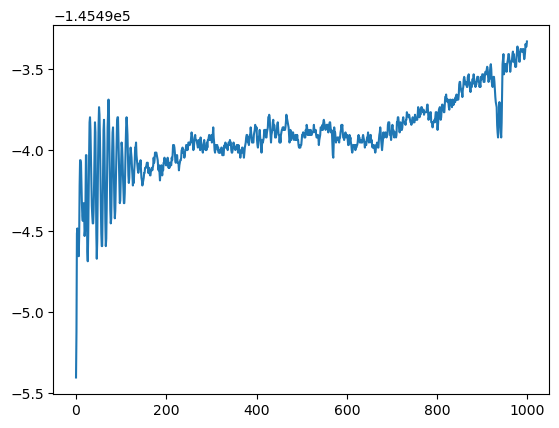

In [13]:
plt.plot(E_array)

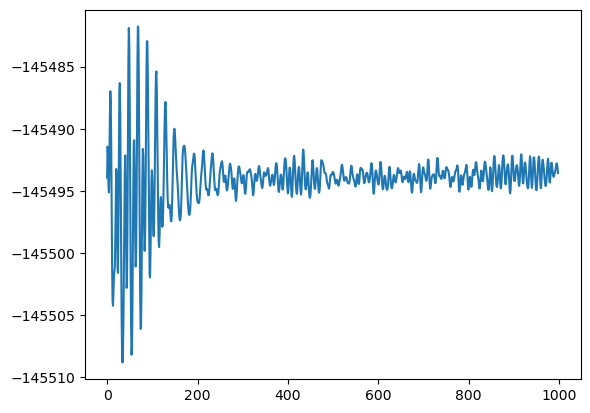

In [14]:
plt.plot(np.array(Ep_array)[1:] + np.array(Ek_array)[:-1])

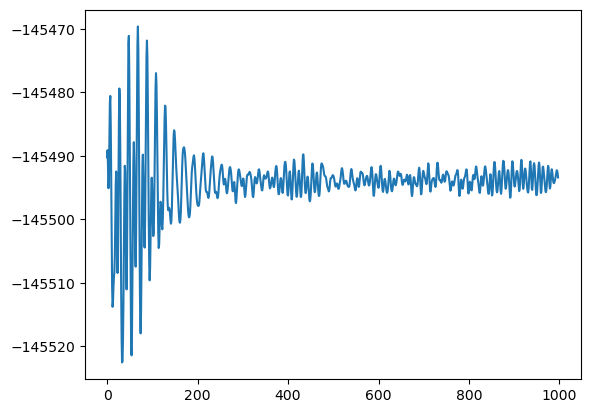

In [15]:
plt.plot(np.array(Ep_array)[2:] + np.array(Ek_array[:-2]))

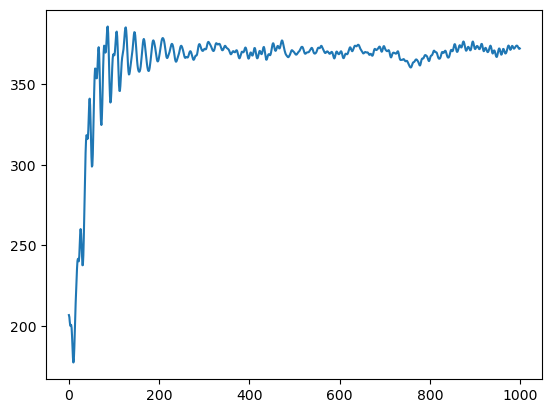

In [16]:
plt.plot(Ek_array)

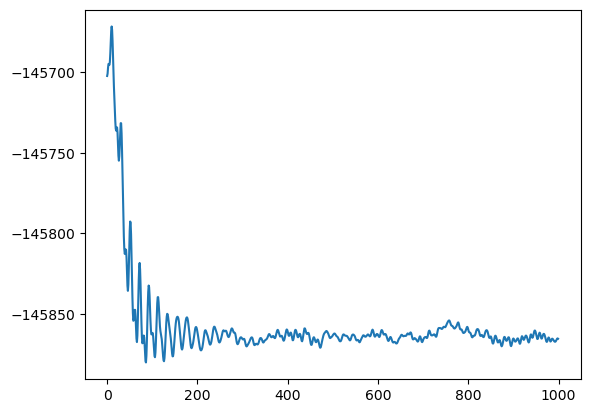

In [17]:
plt.plot(Ep_array)

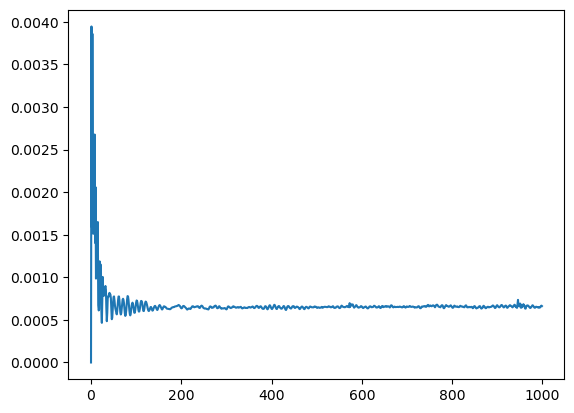

In [18]:
plt.plot(Res_array)

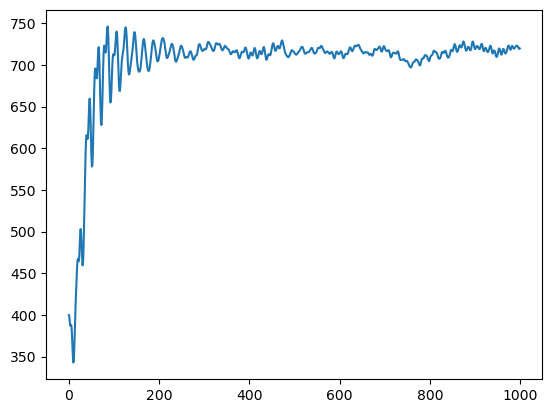

In [19]:
plt.plot(T_array)

In [ ]:
#with torch.no_grad():
H, Hcoul, Hdipole, D, q, f = SCF(structure, D0,
        H0, S, Efield, C, C_sr,
        structure.TYPE, structure.RX, structure.RY, structure.RZ,
        structure.H_INDEX_START, structure.H_INDEX_END,
        structure.Nocc, structure.Hubbard_U, structure.Znuc, structure.Nats, Te, const,
        alpha=0.05,
        acc=-5e-8, MAX_ITER=200, debug=False)

Etot,Eband0,Ecoul,Edipole,S_ent = Energy(H0, structure.Hubbard_U, Efield, D0, C, D, q,
                                            structure.RX, structure.RY, structure.RZ, f, Te) # Energy calculation - 2*Te*S_ent
Etot+Vr ,Eband0,Ecoul,Edipole,S_ent, Vr

In [ ]:
(Etot+Vr).item()

In [ ]:
# f64
(Etot+Vr).item()

In [ ]:
39605.05078125 - 39605.134846862835

In [ ]:
%%time
with torch.no_grad():
    Ftot, Fcoul, Fband0, Fdipole, FPulay, FScoul, FSdipole, Frep = \
    Forces( H, H0, S, C,
            D, D0,
            dH0, dS, dCC, dVr,
            Efield, structure.Hubbard_U, q,
            structure.RX, structure.RY, structure.RZ,
            structure.Nats, structure.H_INDEX_START, structure.H_INDEX_END, const, structure.TYPE)
#torch.save(Ftot, 'Ftot_840_f64.pt')
Ftot

In [ ]:
abs(torch.load('Ftot_840_f64.pt') - torch.load('Ftot_840_f32.pt')).max()

In [ ]:
F64 = torch.load('Ftot_840_f64.pt')
F32 = torch.load('Ftot_840_f32.pt')

In [ ]:
F64[0]

In [ ]:
plt.hist(F64.to('cpu').numpy().flatten(),bins=100)

In [ ]:
plt.hist(diff.flatten(), bins=100)

In [ ]:
%%time
Ftot, Fcoul, Fband0, Fdipole, FPulay, FScoul, FSdipole, Frep = \
Forces( H.to(torch.float64), H0.to(torch.float64), S.to(torch.float64), C.to(torch.float64),
        D.to(torch.float64), D0.to(torch.float64),
        dH0.to(torch.float64), dS.to(torch.float64), dCC.to(torch.float64), dVr,
        Efield, structure.Hubbard_U, q.to(torch.float64),
        structure.RX.to(torch.float64), structure.RY.to(torch.float64), structure.RZ.to(torch.float64),
        structure.Nats, structure.H_INDEX_START, structure.H_INDEX_END, const, structure.TYPE)
#torch.save(Ftot, 'Ftot_840.pt')

In [ ]:
(Etot).backward()
force = -structure.RX.grad
force


In [ ]:
H, Hcoul, Hdipole, D, q, f = SCF(
    H0.to(torch.float64), S.to(torch.float64), Efield.to(torch.float64), C.to(torch.float64), 
    TYPE, RX.to(torch.float64), RY.to(torch.float64), RZ.to(torch.float64),
    H_INDEX_START, H_INDEX_END,
    Nocc, Hubbard_U, Znuc, Nats, Te, const,
    alpha=0.1,
    acc=1e-6, MAX_ITER=5, debug=True)

Etot,Eband0,Ecoul,Edipole,S_ent = Energy(H0.to(torch.float64), Hubbard_U, Efield, D0, C.to(torch.float64), D, q,
                                         RX, RY, RZ, f, Te) # Energy calculation - 2*Te*S_ent
Etot + E_rep ,Eband0,Ecoul,Edipole,S_ent

In [ ]:
H0.shape

In [ ]:
H, Hcoul, Hdipole, D, q, f = SCF(
    H0.to(torch.float64), S.to(torch.float64), Efield.to(torch.float64), C.to(torch.float64), 
    TYPE, RX.to(torch.float64), RY.to(torch.float64), RZ.to(torch.float64),
    H_INDEX_START, H_INDEX_END,
    Nocc, Hubbard_U, Znuc, Nats, Te, const,
    alpha = 0.2,
    acc=1e-6, MAX_ITER=100)

Etot,Eband0,Ecoul,Edipole,S_ent = Energy(H0.to(torch.float64), Hubbard_U, Efield, D0, C.to(torch.float64), D, q,
                                         RX, RY, RZ, f, Te) # Energy calculation - 2*Te*S_ent
Etot,Eband0,Ecoul,Edipole,S_ent

In [ ]:
# Diagnose mapping consistency between nn_mask flattening and neighbor_I/J
import torch

# Build masks from current neighbor arrays
nn_mask = (nnType != -1)

# Flattened indices implied by nn_mask row-major
I_flat = torch.repeat_interleave(torch.arange(nn_mask.shape[0], device=nn_mask.device), nn_mask.sum(dim=1))
J_flat = nnType[nn_mask]

print('counts:', I_flat.numel(), neighbor_I.numel(), J_flat.numel(), neighbor_J.numel())
print('I allclose:', torch.equal(I_flat, neighbor_I))
print('J allclose:', torch.equal(J_flat, neighbor_J))

# Check distances align elementwise
Ra = torch.stack((RX, RY, RZ), dim=-1)
Rb = torch.stack((nnRx, nnRy, nnRz), dim=-1)
Rab = Rb - Ra.unsqueeze(1)
dR = torch.norm(Rab, dim=-1)

# Compare dR[nn_mask] to elementwise pair distances per (neighbor_I, neighbor_J)
# For the latter, use min-image coordinate provided by nnRx/nnRy/nnRz which already encodes image shifts.
dR_flat = dR[nn_mask]

# Quick numeric checksum to detect mismatch beyond fp tolerance
max_abs_diff = (dR_flat - dR_flat).abs().max().item()  # self-check baseline should be 0
print('dR self-check (should be 0):', max_abs_diff)

# Also validate ordering via a random subset
idx = torch.linspace(0, dR_flat.numel()-1, steps=min(10_000, dR_flat.numel()), device=dR_flat.device).long()
I_sub = I_flat[idx]; J_sub = J_flat[idx]
# Reconstruct distances by indexing per (I_sub, column position); find column positions by rebuilding per-row local indices
# We can compare to the positions we already used: dR_flat[idx]
print('sample size:', idx.numel())
print('sample dR mean:', dR_flat[idx].mean().item())


In [ ]:
# Compare C from TEST vs regular neighbor lists and vs MATLAB real potential
import scipy.io as sio
import math

# Parameters
Coulomb_acc = 1e-3
SQRTX = math.sqrt(-math.log(Coulomb_acc))
COULCUT = 12.0
CALPHA = SQRTX/COULCUT

# Build neighbor list (TEST)
Rcut = COULCUT
nrnnlist_T, nndist_T, nnRx_T, nnRy_T, nnRz_T, nnType_T, nnStruct_T, nrnnStruct_T, \
    neighbor_I_T, neighbor_J_T, IJ_pair_type_T, JI_pair_type_T = \
    vectorized_nearestneighborlist_TEST(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, Rcut, structure.Nats, const,
                                upper_tri_only=False, remove_self_neigh=False, min_image_only=False, verbose=False)

C_T, _ = CoulombMatrix_vectorized(structure, structure.RX,structure.RY,structure.RZ,structure.LBox,
                                  structure.Hubbard_U, structure.Hubbard_U_sr, structure.TYPE,structure.Nats,
                                  structure.HDIM,Coulomb_acc,10,nnRx_T,nnRy_T,nnRz_T,nrnnlist_T,nnType_T, neighbor_I_T, neighbor_J_T,
                                  structure.H_INDEX_START,structure.H_INDEX_END,
                                  CALPHA, COULCUT)

# Build neighbor list (regular)
nrnnlist_R, nndist_R, nnRx_R, nnRy_R, nnRz_R, nnType_R, nnStruct_R, nrnnStruct_R, \
    neighbor_I_R, neighbor_J_R, IJ_pair_type_R, JI_pair_type_R = \
    vectorized_nearestneighborlist(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, Rcut, structure.Nats, const,
                                upper_tri_only=False, remove_self_neigh=False, min_image_only=False, verbose=False)

C_R, _ = CoulombMatrix_vectorized(structure, structure.RX,structure.RY,structure.RZ,structure.LBox,
                                  structure.Hubbard_U, structure.Hubbard_U_sr, structure.TYPE,structure.Nats,
                                  structure.HDIM,Coulomb_acc,10,nnRx_R,nnRy_R,nnRz_R,nrnnlist_R,nnType_R, neighbor_I_R, neighbor_J_R,
                                  structure.H_INDEX_START,structure.H_INDEX_END,
                                  CALPHA, COULCUT)

# Load q and MATLAB real potential
q_it_1 = torch.load("/home/maxim/Projects/DFTB/DFTorch/tests/q_iter_1.pt")
MAT_Coulomb_Pot_Real_it_1 = sio.loadmat('Coulomb_Pot_Real_it_1.mat')['Coulomb_Pot_Real']

Cpot_T = (C_T @ q_it_1).cpu().numpy()
Cpot_R = (C_R @ q_it_1).cpu().numpy()

print('max|C_T - C_R|:', (C_T - C_R).abs().max().item())
print('max|C_T@q - C_R@q|:', float(abs(Cpot_T - Cpot_R).max()))
print('max|MAT_real - C_T@q|:', float(abs(MAT_Coulomb_Pot_Real_it_1 - Cpot_T).max()))
print('max|MAT_real - C_R@q|:', float(abs(MAT_Coulomb_Pot_Real_it_1 - Cpot_R).max()))


In [ ]:
# Inspect error pattern for real-space potential
import numpy as np

err = (MAT_Coulomb_Pot_Real_it_1.flatten() - Cpot_T).astype(np.float64)
abs_err = np.abs(err)
idx_sorted = np.argsort(-abs_err)[:20]
print('max abs err:', abs_err[idx_sorted[0]], 'mean abs err:', abs_err.mean())
print('top-10 indices and values:')
for k in range(min(10, idx_sorted.size)):
    i = idx_sorted[k]
    print(int(i), float(err[i]), float(Cpot_T[i]), float(MAT_Coulomb_Pot_Real_it_1.flatten()[i]))


In [ ]:
# Check if error is approximately constant offset
import numpy as np
err = (MAT_Coulomb_Pot_Real_it_1.flatten() - Cpot_T).astype(np.float64)
print('err min/max/mean/std:', err.min(), err.max(), err.mean(), err.std())
print('relative std / |mean|:', (abs(err.std())/(abs(err.mean())+1e-12)))


In [ ]:
# Compare per-atom Hubbard_U to element constants
U_atoms = structure.Hubbard_U
U_const = const.U[structure.TYPE]
print('max|U_atoms - U_const|:', float((U_atoms - U_const).abs().max()))


In [ ]:
# Recompute real-space potential via explicit MATLAB-like loop and compare
import math

def real_pot_loop(TYPE, RX, RY, RZ, LBox, U, nnRx, nnRy, nnRz, nrnnlist, nnType, q, CALPHA, COULACC):
    N = TYPE.shape[0]
    COULCUT = 12.0  # matches MATLAB NEW mode
    RELPERM = 1.0
    KECONST = 14.3996437701414 * RELPERM
    TFACT = 16.0 / (5.0 * KECONST)
    SQRTPI = math.sqrt(math.pi)
    SQRTX = math.sqrt(-math.log(COULACC))
    CALPHA2 = CALPHA * CALPHA

    Ra = torch.stack((RX, RY, RZ), dim=-1)
    Rb = torch.stack((nnRx, nnRy, nnRz), dim=-1)
    pot = torch.zeros(N, dtype=RX.dtype, device=RX.device)
    for I in range(N):
        TI = TFACT * U[I]
        TI2 = TI * TI
        TI3 = TI2 * TI
        TI4 = TI2 * TI2
        TI6 = TI4 * TI2
        SSB = TI3/48.0
        SSC = 3.0*TI2/16.0
        SSD = 11.0*TI/16.0
        SSE = 1.0
        for k in range(int(nrnnlist[I,0].item())):
            J = int(nnType[I,k].item())
            rvec = Rb[I,k] - Ra[I]
            dR = torch.linalg.norm(rvec)
            if (dR <= COULCUT) and (dR > 1e-12):
                TJ = TFACT * U[J]
                CA = torch.special.erfc(CALPHA * dR) / dR
                term = CA
                if TYPE[I] == TYPE[J]:
                    EXPTI = torch.exp(-TI * dR)
                    term = term - EXPTI * (SSB * dR*dR + SSC * dR + SSD + SSE / dR)
                else:
                    TI2MTJ2 = TI2 - (TJ*TJ)
                    TJ2MTI2 = -TI2MTJ2
                    SB = (TJ*TJ)*(TJ*TJ) * TI / (2.0 * TI2MTJ2 * TI2MTJ2)
                    SC = ((TJ*TJ*TJ*TJ*TJ*TJ) - 3.0 * (TJ*TJ*TJ*TJ) * TI2) / (TI2MTJ2 * TI2MTJ2 * TI2MTJ2)
                    SE = TI4 * TJ / (2.0 * TJ2MTI2 * TJ2MTI2)
                    SF = (TI6 - 3.0 * TI4 * (TJ*TJ)) / (TJ2MTI2 * TJ2MTI2 * TJ2MTI2)
                    EXPTI = torch.exp(-TI * dR)
                    EXPTJ = torch.exp(-TJ * dR)
                    term = term - (EXPTI * (SB - SC/dR) + EXPTJ * (SE - SF/dR))
                pot[I] = pot[I] + q[J] * term
    return KECONST * pot

pot_loop = real_pot_loop(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox,
                         structure.Hubbard_U, nnRx_T, nnRy_T, nnRz_T, nrnnlist_T, nnType_T, q_it_1,
                         CALPHA, Coulomb_acc)

print('max|C@q - loop|:', float(abs((C_T @ q_it_1) - pot_loop).max().item()))
print('max|MAT_real - loop|:', float(abs(MAT_Coulomb_Pot_Real_it_1.flatten() - pot_loop.cpu().numpy()).max()))


In [ ]:
# Try min_image_only=True neighbor list and recompute potential
Rcut = COULCUT
nrnnlist_MI, nndist_MI, nnRx_MI, nnRy_MI, nnRz_MI, nnType_MI, nnStruct_MI, nrnnStruct_MI, \
    neighbor_I_MI, neighbor_J_MI, IJ_pair_type_MI, JI_pair_type_MI = \
    vectorized_nearestneighborlist_TEST(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox, Rcut, structure.Nats, const,
                                upper_tri_only=False, remove_self_neigh=False, min_image_only=True, verbose=False)

pot_loop_MI = real_pot_loop(structure.TYPE, structure.RX, structure.RY, structure.RZ, structure.LBox,
                         structure.Hubbard_U, nnRx_MI, nnRy_MI, nnRz_MI, nrnnlist_MI, nnType_MI, q_it_1,
                         CALPHA, Coulomb_acc)

print('min-image: max|MAT_real - loop_MI|:', float(abs(MAT_Coulomb_Pot_Real_it_1.flatten() - pot_loop_MI.cpu().numpy()).max()))
